## EfficientNet

1. データの前処理
2. Datasetの作成
3. DataLoaderの作成
4. モデルの作成
5. 順伝播の定義
6. 損失関数の定義
7. 最適化手法の設定
8. 学習・検証の実施
9. テストデータで推論

### 0.ライブラリ

In [140]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.transforms.functional import to_pil_image
from torchinfo import summary
%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.  データの前処理

#### データの確認

Shape: (500, 375, 3)
Value Range: 0-255


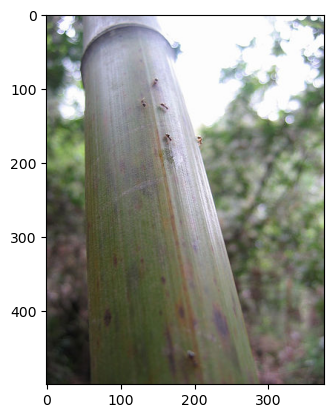

In [119]:
# データセットのディレクトリ
data_dir = "/Users/hisashi/Desktop/git-hub/deep-learning/hymenoptera_data"
# 画像の確認
img = cv2.imread(os.path.join(data_dir, "val", "ants", "8124241_36b290d372.jpg"))
print(f"Shape: {img.shape}")
print(f"Value Range: {img.min()}-{img.max()}")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#### transform

In [120]:
# 検証データ用
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 訓練データ用
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

### 2. Datasetの作成

In [121]:
# 訓練データと検証データのディレクトリ
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
# 分類先クラスのリスト作成
classes = ['ants', 'bees']

# データセットの作成
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_dataset_sample = datasets.ImageFolder(train_dir, transform=train_transform)   #イメージ表示用
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

# データ件数確認
print('train_dataset:', len(train_dataset))
print('val_dataset:', len(val_dataset))

train_dataset: 244
val_dataset: 153


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

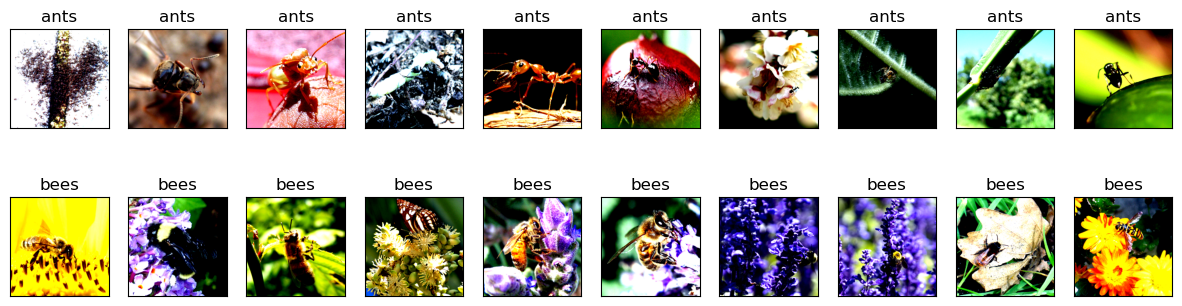

In [122]:
# Datasetの確認
plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = val_dataset[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1) / 2
    plt.imshow(img)
    ax.set_title(f"{classes[label]}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = val_dataset[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1) / 2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 3. DataLoaderの作成

In [123]:
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### 4. Modelの作成

In [124]:
# 事前学習済みモデルの読み込み
model = models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')

<bound method Module.parameters of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine

In [143]:
# 構造の確認
display(summary(model, input_size=(batch_size, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [10, 2]                   --
├─Sequential: 1-1                                       [10, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [10, 24, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [10, 24, 112, 112]        648
│    │    └─BatchNorm2d: 3-2                            [10, 24, 112, 112]        48
│    │    └─SiLU: 3-3                                   [10, 24, 112, 112]        --
│    └─Sequential: 2-2                                  [10, 24, 112, 112]        --
│    │    └─FusedMBConv: 3-4                            [10, 24, 112, 112]        5,232
│    │    └─FusedMBConv: 3-5                            [10, 24, 112, 112]        5,232
│    └─Sequential: 2-3                                  [10, 48, 56, 56]          --
│    │    └─FusedMBConv: 3-6                         

In [125]:
# 2クラス分類に変更
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)

### 6. 損失関数の定義

In [127]:
# 損失関数
criterion = nn.CrossEntropyLoss()

### 7. 最適化手法の設定

#### 転移学習

In [128]:
# # 全てのパラメータで勾配計算を無効化
# for param in model.parameters():
#     param.requires_grad = False
# # 最終層のパラメータのみ勾配計算を有効化
# model.classifier[1].requires_grad = True

# # 学習率
# lr = 0.001
# # 最適化関数
# optimizer = torch.optim.SGD(model.classifier[1].parameters(), lr=lr, momentum=0.9)

#### ファインチューニング

In [129]:
# 学習率
lr = 0.001
# 最適化関数
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

### 8. 学習・検証の実施

In [133]:
# epoch数
num_epochs = 1
# 学習
train_losses, val_losses, val_accuracies = utils.learn(model=model,
                                                       train_loader=train_loader,
                                                       val_loader=val_loader,
                                                       optimizer=optimizer,
                                                       loss_func=criterion,
                                                       num_epoch=num_epochs,
                                                       early_stopping=None,
                                                       save_path=fr'/Users/hisashi/Desktop/git-hub/deep-learning/sample.pth'"",
                                                       scheduler=None)

epoch: 0: train error: 0.472609281539917, validation error: 0.29211670346558094, validation accuracy: 0.9374999962747097


### 9. テストデータでの推論

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

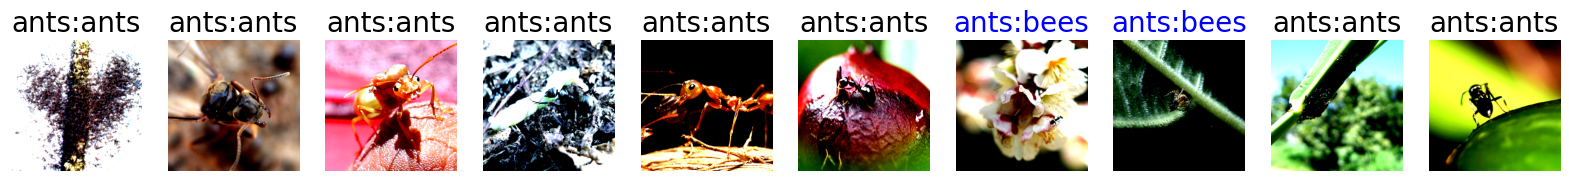

In [138]:
utils.show_images_labels(val_loader, classes, model, 'cpu')

### Learning Rate Scheduler

In [ ]:
# 学習率のスケジューラ設定
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# デバイスの設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# モデルの訓練
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 各エポックに対して訓練と検証を実施
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # モデルを訓練モードに設定
            else:
                model.eval()   # モデルを評価モードに設定

            running_loss = 0.0
            running_corrects = 0

            # データをバッチごとにループ
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # パラメータの勾配をゼロにリセット
                optimizer.zero_grad()

                # 順伝播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 訓練時のみバックプロパゲーションとオプティマイズを実行
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 損失と正解数の統計を更新
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # モデルのベストパフォーマンスを保持
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # ベストモデルの重みをロード
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

# モデルの保存
#torch.save(model.state_dict(), 'efficientnetv2_best_model.pth')